# Loading and splitting dataset

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Dataset https://huggingface.co/datasets/carblacac/twitter-sentiment-analysis

df_train = pd.read_csv('data/train_english.txt', sep='\t', names=('sentimiento', 'tweet')) 
df_test = pd.read_csv('data/test_english.txt', sep='\t', names=('sentimiento', 'tweet')) 

df_train.rename(columns={'etiqueta': 'sentimiento', 'texto': 'tweet'}, inplace=True)
df_test.rename(columns={'etiqueta': 'sentimiento', 'texto': 'tweet'}, inplace=True)

# Split test dataset into validation and test
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

print(df_train.shape, df_val.shape, df_test.shape)

(149985, 2) (30999, 2) (30999, 2)


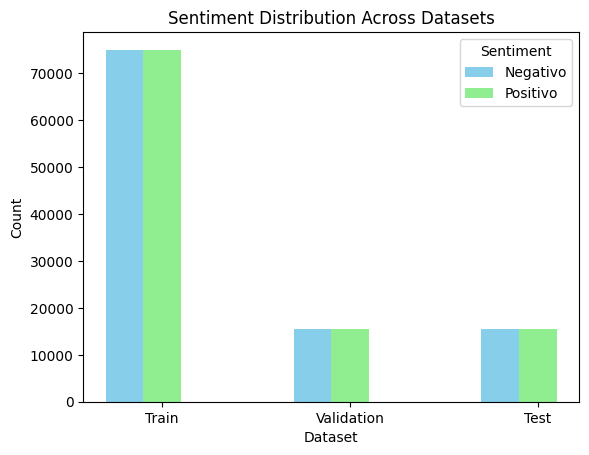

In [3]:
# Overview
import matplotlib.pyplot as plt 
import numpy as np 

train_vl = df_train['sentimiento'].value_counts()
val_vl = df_val['sentimiento'].value_counts()
test_vl = df_test['sentimiento'].value_counts()

x = np.arange(3)
y1 = [train_vl[0], val_vl[0], test_vl[0]] 
y2 = [train_vl[1], val_vl[1], test_vl[1]] 
width = 0.2

plt.bar(x - 0.2, y1, width, color='skyblue') 
plt.bar(x, y2, width, color='lightgreen') 
plt.xticks(x, ['Train', 'Validation', 'Test']) 
plt.title('Sentiment Distribution Across Datasets')
plt.xlabel("Dataset") 
plt.ylabel("Count") 
plt.legend(["Negativo", "Positivo"], title='Sentiment') 
plt.show() 

# Text Pre-Processing

In [4]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop = stopwords.words('english')

df_train['tweet'] = df_train['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_val['tweet'] = df_val['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_test['tweet'] = df_test['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df_train

,sentimiento,tweet
0,0,Starting back work today Looks like it'll rain...
1,1,Sugar levels dropping... munchies setting in. ...
2,1,@karineb22 yeah!!! great summer break!
3,1,hannah montana good. going read twilight.
4,1,"@Mayra326 aww, fun! I 3D last week!"
...,...,...
149980,0,Had great night Tabs I'm missing Chad Going bed.
149981,1,What night work.. Church morning
149982,0,book terrible im used 2 reading make believes ...
149983,0,"@backstreetboys Updates? Any? I miss updates, ..."


# Encode the Input Token

In [6]:
import torch
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Strings to a tensor of encoded token IDs
# Special tokens as: CLS SEP
# All inputs are truncated to 90 tokens
# Pad the input with zeros

def encoding_process(content):
    get_ids = []    
    for text in content:
        input_ids = tokenizer.encode(text, add_special_tokens = True, max_length = 90, pad_to_max_length = True,  return_tensors = 'pt')
        get_ids.append(input_ids)    
    get_ids = torch.cat(get_ids, dim=0)
    return get_ids

c:\Users\LENOVO\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 7.94kB/s]
c:\Users\LENOVO\AppData\Local\Programs\Python\Python38\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activ

In [7]:
# make sure return_dict is not default
return_dict = False

# Training dataset 
content = df_train['tweet'].values
labels = df_train['sentimiento'].values
get_ids = encoding_process(content)
labels = torch.tensor(labels)

# Validation dataset
val_content = df_val['tweet'].values
val_labels = df_val['sentimiento'].values
val_get_ids = encoding_process(val_content)
val_labels = torch.tensor(val_labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\LENOVO\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [9]:
print(get_ids)

tensor([[  101,  3225,  2067,  ...,     0,     0,     0],
        [  101,  5699,  3798,  ...,     0,     0,     0],
        [  101,  1030, 24537,  ...,     0,     0,     0],
        ...,
        [  101,  2338,  6659,  ...,     0,     0,     0],
        [  101,  1030, 10457,  ...,     0,     0,     0],
        [  101,  1030, 24123,  ...,     0,     0,     0]])


In [23]:
import transformers
import random

print(transformers.__version__)
seed = 38
device = torch.device('cuda')
print('\n')
print(device)

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

4.35.2


cuda


In [15]:
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification
from transformers import AdamW
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

epochs = 3
batch_size = 16

# epochs: hyperparameter of gradient descent that controls the number of complete passes through the training dataset.
# batch_size: hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.

train_dataloader = torch.utils.data.DataLoader(get_ids, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_get_ids, batch_size=batch_size, shuffle=True, num_workers=2)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, output_attentions=False, output_hidden_states=False)
model.cuda()
optimizer = AdamW(model.parameters(), lr=2e-5)
output_model = './content/model/imdb_bert.pth'
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def save(model, optimizer):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model)

def accuracy_calc(preds, labels):
    pre = np.argmax(preds, axis=1).flatten()
    real = labels.flatten()
    return accuracy_score(real, pre)

def f1_accuracy(preds, labels):
    
    pre = np.argmax(preds, axis=1).flatten()
    real = labels.flatten()
    return f1_score(real, pre)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
from transformers import BertModel
import torch.nn as nn

class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

        # Dropout layer 
        self.dropout = nn.Dropout(0.2) 

        # Output layer
        self.out = nn.Linear(768, 2)  

        # Softmax activation function
        self.softmax = nn.LogSoftmax(dim=1) 
    def forward(self, input, mask):
        _, pooled_output = self.bert(
          input_ids = input,
          attention_mask = mask
        )
        output = self.dropout(pooled_output)
        output = self.softmax(output)
        return self.out(output)

model = BERT().to(device)


In [25]:
# 💥 IMPORTANT: Please create the directory in your environment, 
# such like './content/model/', in order to save your model in your local!
for epoch in range(epochs):
    model.train()
    total_loss, total_val_loss = 0, 0
    total_eval_accuracy = 0
    _f1 = 0
    _train_f1 = 0
    for step, batch in enumerate(train_dataloader):
        model.zero_grad()
        loss, tval_ = model(
            batch[0].to(device), 
            token_type_ids=None, 
            attention_mask=(batch[0]>0).to(device), 
            labels=batch[1].to(device),
            return_dict = False
        )
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step() 
        scheduler.step()
        tval_ = tval_.detach().cpu().numpy()
        label_ids = batch[1].to('cpu').numpy()
        _train_f1 += f1_accuracy(tval_, label_ids)
        
    model.eval()
    for i, batch in enumerate(val_dataloader):
        with torch.no_grad():
            loss, val_ = model(batch[0].to(device), token_type_ids=None, attention_mask=(batch[0]>0).to(device), labels=batch[1].to(device),return_dict = False)
                
            total_val_loss += loss.item()
            
            val_ = val_.detach().cpu().numpy()
            label_ids = batch[1].to('cpu').numpy()
            total_eval_accuracy += accuracy_calc(val_, label_ids)
            _f1 += f1_accuracy(val_, label_ids)
    
    training_loss = total_loss / len(train_dataloader)
    valid_loss = total_val_loss / len(val_dataloader)
    _accuracy = total_eval_accuracy / len(val_dataloader)
    _f1_score = _f1 / len(val_dataloader)
    train_f1_score = _train_f1/ len(train_dataloader)
    
    print('Training loss is', training_loss)
    print('Valid loss is:', valid_loss)
    print('Acc score is:', _accuracy)
    print('F1_score is:', _f1_score)
    print('train_F1_score is:', train_f1_score)
    print('\n')

save(model, optimizer)

ValueError: not enough values to unpack (expected 2, got 1)